In [1]:
import math
import numpy as np
from qiskit import *
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit import IBMQ
import matplotlib
%matplotlib inline

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [120]:
def loadQuantumImage(path):
    from PIL import Image
    image= Image.open(path)
    (width, height) = image.size
    pixels = image.load()

    ssum = 0
    for i in range(width):
        for j in range(height):
            ssum += pixels[i,j]**2

    m = math.floor(math.log(height, 2))
    n = math.floor(math.log(width, 2))
    stateVector = np.zeros(2**(m+n))
    for i in range(width):
        for j in range(height):
            stateVector[i*height + j] = pixels[i,j]/math.sqrt(ssum)
            
    return stateVector, m, n

In [121]:
def exportQuantumImage(counts, shots, height, width):
    from PIL import Image

    r = math.floor(math.log(width, 2))
    im= Image.new("L", (width, height))
    pixels = im.load()

    maxAmplitude = 256
    medAmplitude = maxAmplitude/2
    med = shots/(height * width)
    for key in counts:
        i = int(key[0:r], 2)
        j = int(key[r:], 2)
        val = round((((counts[key] - med)/med)*medAmplitude) + medAmplitude)
        pixels[i,j] = (val)
        
    return im

In [316]:
def Increment(increment, quantumRegister, circuit):
    from qiskit.aqua.components.qfts import Standard as qft
    from qiskit.aqua.components.iqfts import Standard as iqft
    
    n = quantumRegister.size
    
    iqft(n).construct_circuit(qubits=quantumRegister,circuit=circuit)
    
    for j in range(n):
        circuit.u1((np.pi*increment)/(2**(n-1-j)), quantumRegister[j])
        
    iqft(n).construct_circuit(qubits=quantumRegister,circuit=circuit)
    

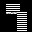

In [228]:
stateVector, m, n = loadQuantumImage('boxes.bmp')

circ = QuantumCircuit(m+n, m+n)
indexes = range(m+n)

state = [complex(x) for x in stateVector]
circ.initialize(state, indexes)

# for a in range(2**n):
#     for idx in indexes[:-1]:
#         circ.swap(idx, idx+1)

# for idx in indexes[:0:-1]:
#     circ.swap(idx, idx-1)

# circ.x(indexes)
circ.h(0)
#circ.x(indexes)
circ.measure(indexes, indexes)


provider = IBMQ.get_provider(group='open')
localSimulator = Aer.get_backend('qasm_simulator')
backend = provider.get_backend('ibmq_qasm_simulator')

#2**(m+n)*10
shots = 2**(m+n)*10 # 8190
result = execute(circ, localSimulator, shots=shots).result()
counts = result.get_counts(circ)
counts

counts2 = {}
for key in counts:
    if key[m+n-1] == '1':
        counts2[key] = counts[key]


exportedImg = exportQuantumImage(counts, shots, 2**m, 2**n)
exportedImg

In [218]:
exportedImg.show()

In [216]:
for idx in indexes[:0:-1]:
    print(idx)

2
1


In [318]:
from qiskit.aqua.components.qfts import Standard as qft
from qiskit.aqua.components.iqfts import Standard as iqft

n2 = 4
qreg = QuantumRegister(n2)
creg = ClassicalRegister(n2)
circ2 = QuantumCircuit(qreg, creg)
indexes2 = range(n2)
increment = 7

circ2.x(0)
circ2.barrier()

Increment(increment, circ2.qubits, circ2)

# sqft = qft(n2)
# siqft = iqft(n2)
# sqft.construct_circuit(qubits=circ2.qubits,circuit=circ2)

# # for j in range(n2):
# #     #R1Frac(increment, (d - 1) - j, (target!)[j]);
# #     circ2.u1((np.pi*increment)/(2**(n2-1-j)), circ2.qubits[j])

# siqft.construct_circuit(qubits=circ2.qubits,circuit=circ2)

circ2.measure(indexes2, indexes2)

localSimulator2 = Aer.get_backend('qasm_simulator')

shots2 = 1024
result2 = execute(circ2, localSimulator2, shots=shots2).result()
counts2 = result2.get_counts(circ2)
counts2

{'1000': 1024}